# Are you part of a Social Tribe?
### Leveraging Twitter data to understand our social network connections

This notebook contains the main script used in the Medium.com article _Are you part of a Twitter Tribe?_, you can check the motivation and background for this script in this [url](https://medium.com/@alvaroaguado3/are-you-part-of-a-twitter-tribe-6cd1201800e6)

Here we will only focus in the process and computation of the data. We will not go through all the ethical implications and considerations other users should have in order to re-use this data. However, it is important to mention that this code should be used ensuring respect for personal privacy and proper use of the Terms of Service. We recommend this article on the [topic](https://medium.com/@cfiesler/spiders-and-crawlers-and-scrapers-oh-my-law-and-ethics-of-researchers-violating-terms-of-service-27496894f6de)




#### Accessing Twitter data - Set up Account

In order to access Twitter data we need to 1) Have a Twitter account, and 2) Create an API. 
A tutorial on how to create an account and create an API can be found [here](https://towardsdatascience.com/how-to-use-twitters-api-c3e25c2ad8fe) 

Here are a few screenshots of how is this done.

1- Go to [apps.twitter.com](https://developer.twitter.com/en/apps)
[]('\Figures\1_Go_to_apps_twitter.JPG')
<br>
2- Create the App
<br>
3- Get the token details
<br>
4- Get the Bearer Token
<br>

#### Accessing Twitter data - Getting the data on Python

Now that you have the credentials we will go in and extrac the data with [tweepy](http://docs.tweepy.org/en/latest/index.html)
First we need to make sure tweepy is installed


In [5]:
## Install tweepy #Uncomment the below lines if you have the packages already
#!pip install tweepy 
#!pip install time 
#!pip install json 
#!pip install networkx
#!pip install matplotlib

In [2]:
# Magic line to ensure plotting happens in Jupyter
%matplotlib inline

# Import libraries for the code
import time
import json
import tweepy
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [154]:
# Set up plot size
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [4]:
# Paste here your api_key and secret
api_key = "YOUR-KEY"
api_secret = "YOUR-SECRET"

# Now we use the configured authentication information to connect
# to Twitter's API
auth = tweepy.AppAuthHandler(api_key, api_secret)

api = tweepy.API(auth)

print("Connected to Twitter!")


Connected to Twitter!


### The experiment

Since Twitter has some tight restrictions on the number of pulls you can do in every session we are going to device a method that does a sample of the connections you have. From that sample we will estimate our measures of degree, closeness and other centrality measures. Of course the sample might not be suitable for all users given that the number of account each follows could vary.

First we are going to device a handler for the time limits that the api has. The function will stop whenever we exceed the request limits set by Twitter

In [1]:
# Handler for waiting if we exhaust a rate limit
# @Author: Cody Buntain
def limit_handled(cursor):
    ''' 
    Function takes a cursor item from tweepy api and checks if the rate status has been exceeded, 
    if so then computer sleeps until time is reset
    inputs_
    cursor: str tweepy.cursor element 
    outputs_
    cursor: str tweepy.cursor element
    '''
    while True:

        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            # Determine how long we need to wait...
            s = api.rate_limit_status()
            dif = s["resources"]['friends']['/friends/list']['reset'] - int(time.time())
            
            # If we have a wait time, wait for it
            if ( dif > 0 ):
                print("Sleeping for %d seconds..." % dif)
                time.sleep(dif)
        except:
            break

Now we create a function that extracts the list of friends of a given twitter user. 

In [43]:
def extract_friends(api,base,limit = 5):
    '''
    Function extracts all the friends from a given twitter account screen name
    Output:
    df dataframe , list of friends of a given account
    '''
    orig = []
    ids = []
    friends = []
    followers = []
    
    for friend in limit_handled(tweepy.Cursor(api.friends, id=base).items(limit)):
        orig.append(base)
        ids.append(friend.screen_name)
        friends.append(friend.friends_count)
        followers.append(friend.followers_count)
        
    df = pd.DataFrame(list(zip(orig,ids,friends,followers)), columns = ['orig','target','friends','followers'])                

    return df

In [78]:
def sample_friends(base_df, threshold = 200,sample = 5, seed = 12345):
    '''
    Function takes output from convert_friends and filters the list based on a threshold = 200,
    '''
    base_df_filtered = base_df[base_df['followers'] <= 200]
    base_df_filtered_sampled = base_df_filtered.sample(sample, random_state = seed)
    
    return(base_df_filtered_sampled.target)


In [87]:
def loop_extract(api, base_list, limit = 5):
    '''
    Function takes a list of screen_names and returns a full table with all their friends
    '''
    lst = []
    for base_item in base_list:    
        lst.append(extract_friends(api=api, base = base_item, limit = limit))
    
    super_df = pd.concat(lst)
    return(super_df)    

In [46]:
# Get all the connections for me
base = "neuronalnet"
base_df = extract_friends(api= api, base = base, limit = 300)
base_df

,orig,target,friends,followers
0,neuronalnet,Sai00079520,12,3
1,neuronalnet,Lotus_Reverie,2509,1369
2,neuronalnet,analyticsrl,79,159
3,neuronalnet,chhlss,838,69793
4,neuronalnet,AMAZlNGSCIENCE,41178,525537
...,...,...,...,...
253,neuronalnet,GovernorBullock,710,196428
254,neuronalnet,SeriousStrange,1,878600
255,neuronalnet,WorldAndScience,11091,2058619
256,neuronalnet,RWPUSA,293,726582


Then based on the number of friends and followers these users have we randomly select a subset of them. This subset sample is based on the number of friends and followers they have. We will dismiss those twitter users that have the status of influencers. This means we will only pic users that have a number of friends and followers below a certain threshold. 

Then from this subsample we will extract all the followed accounts as well.

In [83]:
# Get the sample
sample = sample_friends(base_df,threshold = 200, sample = 4, seed = 10)
base_df[base_df['target'].isin(sample)]

,orig,target,friends,followers
0,neuronalnet,Sai00079520,12,3
52,neuronalnet,osuna_vasco,103,52
58,neuronalnet,gandyno,230,112
72,neuronalnet,sarayeinguer,313,104


In [89]:
# Loop through the sampled friends and see their connections 
## This may take sometime since we might exceed the limit of request pretty quickly, keep the limit below 300
sdf = loop_extract(api = api, base_list = sample, limit = 300)
sdf

Sleeping for 798 seconds...


,orig,target,friends,followers
0,osuna_vasco,lgespana,1626,81936
1,osuna_vasco,XboxStudio,573,7829
2,osuna_vasco,DrBioblogo,623,56471
3,osuna_vasco,_RetosNBA_,1,5774
4,osuna_vasco,RaraAvisDH,71,152
...,...,...,...,...
295,sarayeinguer,Ale_melli_,197,172
296,sarayeinguer,PacoAGarcia,112,134
297,sarayeinguer,juanp_arQtistic,185,151
298,sarayeinguer,EvaHernandezGar,136,100


Now that we have the full list of connections from me and a few of my friends we can build our network from this sample. First let's create a function that will combine my full list of connections with the full list of connections from a few of my friends

In [385]:

def convert_dfs(raw_network):
    '''
    Function takes the original network of connections and the connection of sample of friends and 
    returns a networkx ready table
    '''    
    raw_network_crosstab = pd.crosstab(raw_network.orig,raw_network.target)
    idx = raw_network_crosstab.columns.union(raw_network_crosstab.index)
    network = raw_network_crosstab.reindex(index = idx, columns = idx, fill_value = 0)
    return network    
    

In [160]:
#Create the graph friendly table for me and my friends connections
combined_df = pd.concat([base_df,sdf])
raw_network  = combined_df.loc[:,["orig","target"]]

dfg = convert_dfs(raw_network)
dfg

,20m,8kras,9GAG,A380Paco,A3Noticias,AMAZlNGSCIENCE,AP,Abengoa,Advei,AdvilRelief,...,wonderofscience,xaviconde,xavieraldekoa,xieyihui,xkcdComic,xkcd_rss,yanko002,yeyodebote,yuyudecai,zim2918
20m,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8kras,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9GAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A380Paco,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A3Noticias,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xkcd_rss,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yanko002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yeyodebote,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yuyudecai,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can start visualizing the network. At this point you may anticipate what's going to happen if we just throw in this table. Basically the network will be so full that it will be impossible to see what's each connection. Even if we remove the labels. However, even with this you can more or less where are the different hubs. 

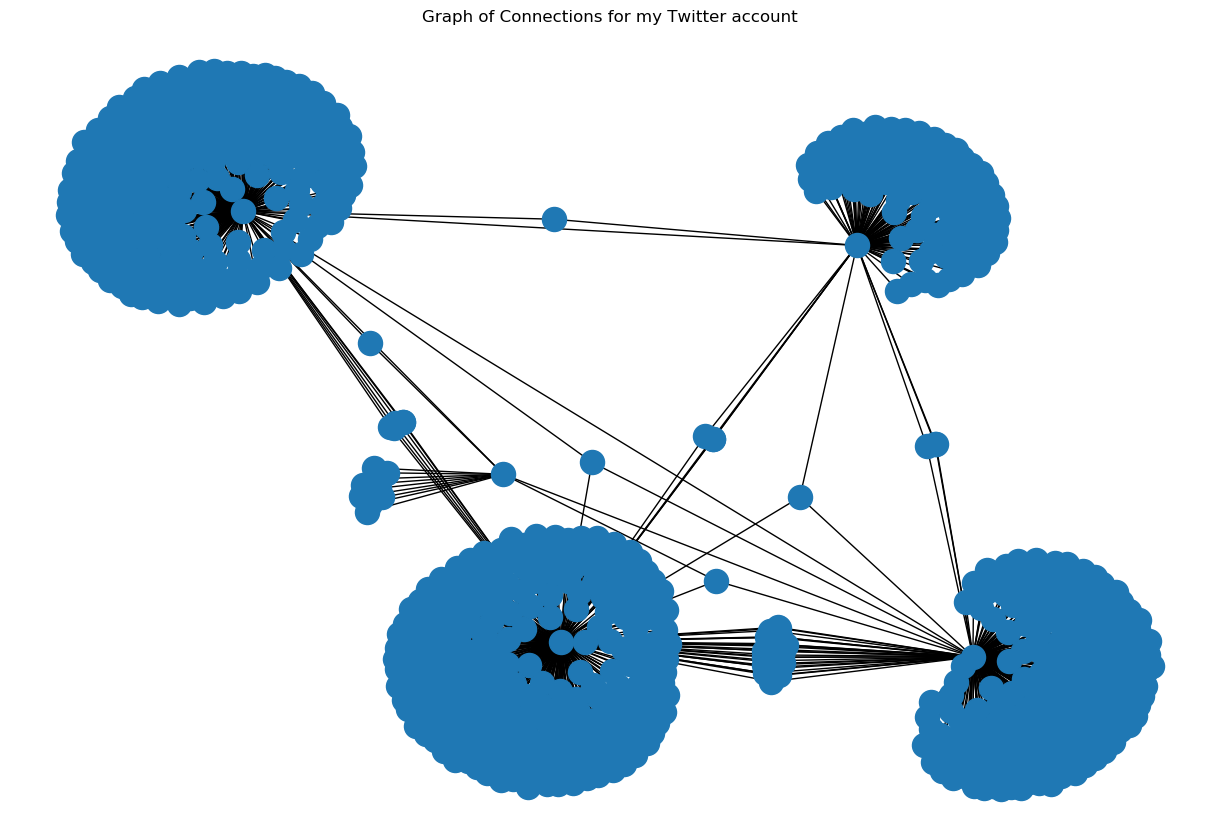

In [408]:
# Create a raw graph 
np.random.seed(42)
G = nx.from_pandas_adjacency(dfg)
pos = nx.spring_layout(G)
nx.draw(G,pos = pos,with_labels=False)
plt.title('Graph of Connections for my Twitter account')
plt.show()

Yes, the big hubs belong to 3 of my 4 friends. And there's another person that is pretty new to Twitter, and as result does not have a lot of connections. But it's almost impossible to understand what's happening here. So let's clean up the plot and show some labels.

We are interested in knowing which nodes belong to my friends and also what are some of the accounts with 'influencer' status that we follow. In order to do this second step we need to create a list of weights for the nodes. 

We are going to do this by selecting accounts with a large number of followers. We will then normalize the weight dividing by the maximum number of followers in the list. We will only then qualify accounts that are (arbitrarily to me) large.

In [395]:
# Get node weights
def get_weights(combined_df,dfg ,filter_thres = 200 ):
    weights = combined_df.loc[:,['target','followers']].groupby(['target']).first()
    weights_filtered = weights[weights.index.isin(dfg.index)]
    weights_normalized = np.round(weights_filtered.followers/max(weights_filtered.followers),2)*10000
    weights_normalized = np.round(weights.followers/max(weights.followers),2)*1000
    influencers = weights_normalized[weights_normalized>filter_thres]
    return influencers, weights_normalized


In [398]:
# Get influencers and weights
influencers, weights_normalized = get_weights(combined_df,dfg = dfg ,filter_thres = 200 )
influencers_me, weights_normalized_me = get_weights(base_df,dfg = dfg2, filter_thres = 200 )

We also want to create a list of label names for those nodes we want to label in our graph. We will create a list of labels for my friends and another one for the influencers.

In [470]:
# Create specific labels

node_in1 = np.concatenate([pd.Series(base).append(sample).values])
node_in2 = np.concatenate([influencers.index.to_series().values])
node_in3 = np.concatenate([influencers_me.index.to_series().values])


def color_labels(G,node_in):    
    labels = {}    
    for node in G.nodes():
        if node in node_in:
            #set the node name as the key and the label as its value 
            labels[node] = node
    return labels    

labels1 = color_labels(G,node_in1)
labels2 = color_labels(G,node_in2)
labels3 = color_labels(G,node_in3)

Finally we can visualize what we have done and start working on understanding what our network is made of. 

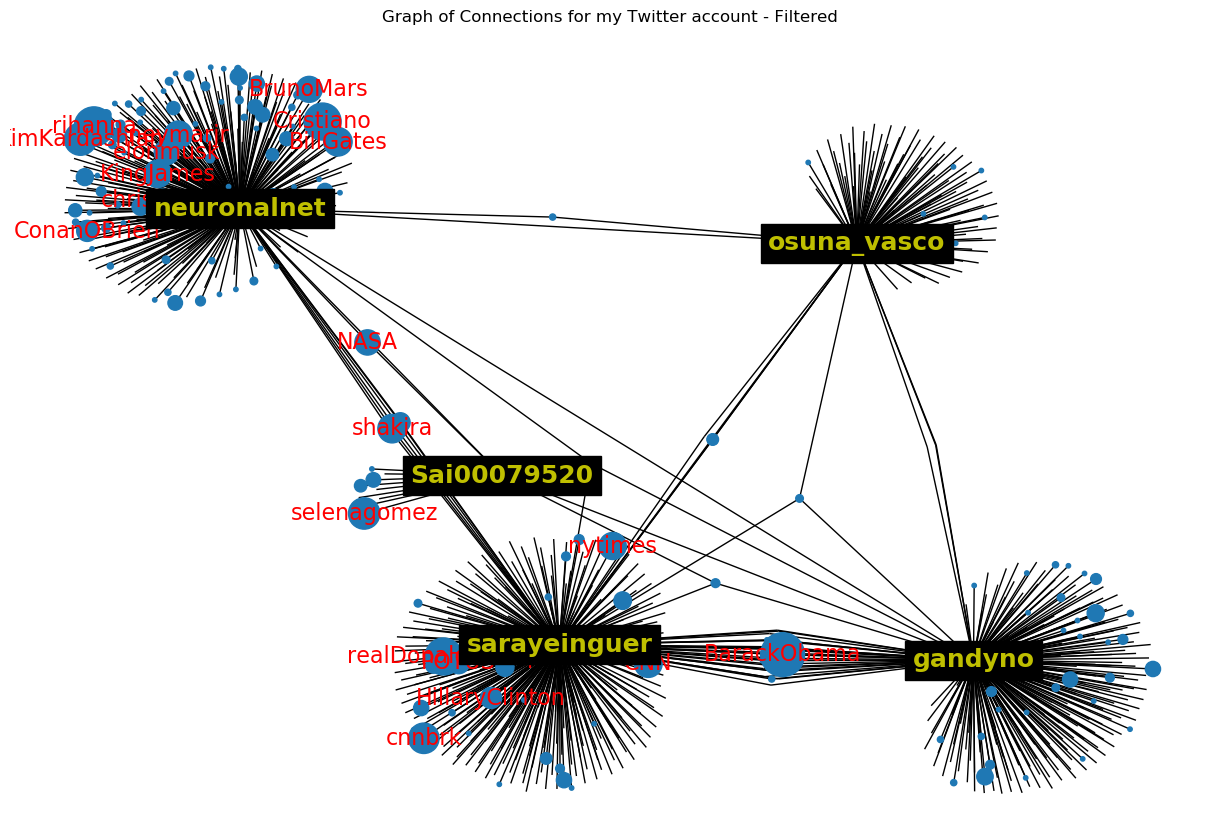

In [313]:
# Create adjacency table from the table of connections and 
np.random.seed(42)
bbox = dict(fc="black", ec="black", boxstyle="square", lw=1)
G = nx.from_pandas_adjacency(dfg)
pos = nx.spring_layout(G)
nx.draw(G,pos = pos,with_labels=False, node_size = weights_normalized)
nx.draw_networkx_labels(G,pos = pos,labels = labels2,font_size=16,font_color='r')
nx.draw_networkx_labels(G,pos = pos,labels = labels1,font_size=18,font_color='y', font_weight = 'bold',bbox = bbox)
plt.title('Graph of Connections for my Twitter account - Filtered')
plt.show()

We can still have some trouble getting what's happening here but it's also true that now it's easier to see how we are connected to each other. And we can see that I don't really share too many connections with my friends. 
But 2 of my friends do share a large amount of connections with one another.  What's interesting is some of them share many more connections than I do.   


Let's run some initial metrics to understand our network. 
Let's get the degree, diameter and density of our graph 

In [325]:
# Degree of our graph
centrality = nx.degree_centrality(G)
df_degreeCentrality = pd.DataFrame([(x, centrality[x]) for x in sorted(centrality, key=centrality.get, reverse=True)],columns = ['User','Degree Centrality'])

# Show the top 10 cases 
df_degreeCentrality.head(10)

,User,Degree Centrality
0,sarayeinguer,0.352113
1,neuronalnet,0.302817
2,gandyno,0.269953
3,osuna_vasco,0.122066
4,Sai00079520,0.015258
5,IbaiLlanos,0.003521
6,JustinTrudeau,0.003521
7,elmundoes,0.003521
8,BarackObama,0.002347
9,BryanCranston,0.002347


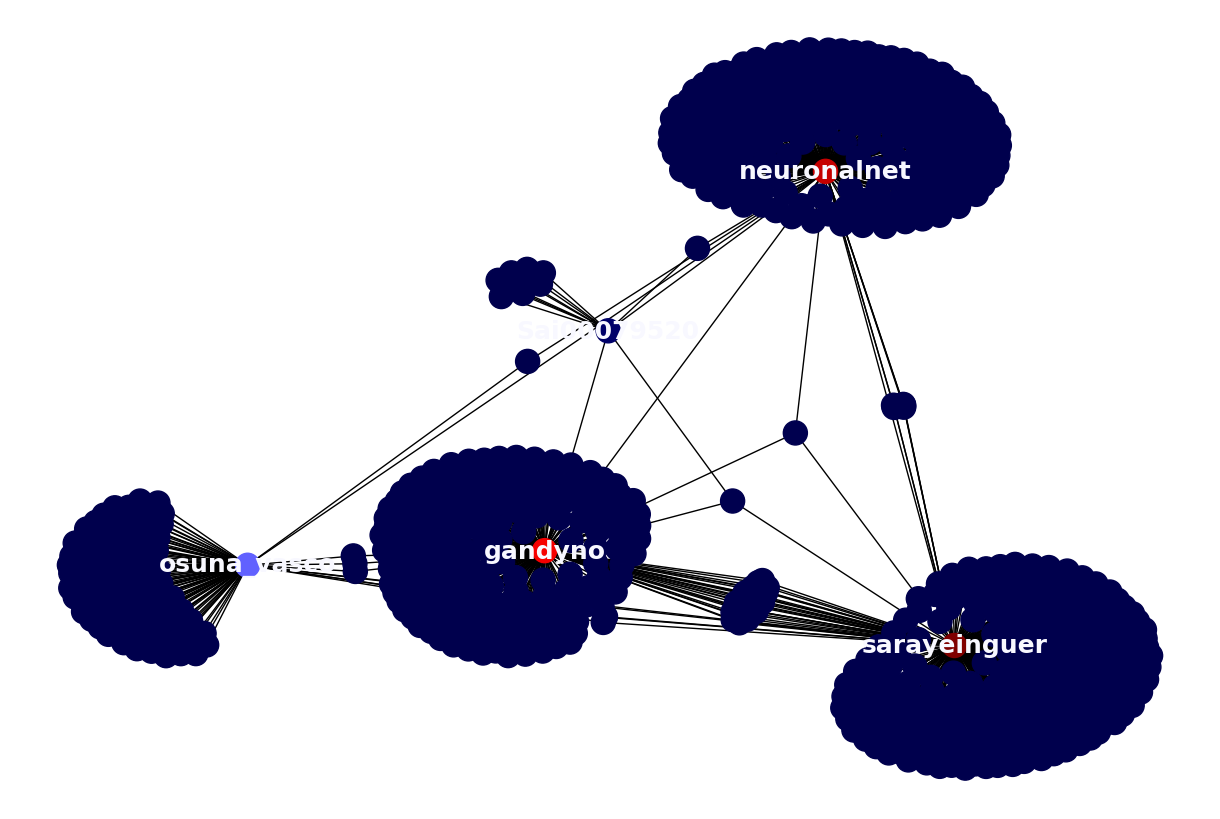

In [469]:
# Color by centrality
pos = nx.spring_layout(G, iterations=200)
max_c = max(centrality.values())
color_map = {x[0]:x[1]/max_c for x in centrality.items()}
# Randomly color

nx.draw(G, pos, node_color=list(color_map.values()), cmap=plt.cm.seismic)
nx.draw_networkx_labels(G,pos = pos,labels = labels1,font_size=18,font_color='ghostwhite', font_weight = 'bold')
plt.show()

Degree Centrality is the fraction of nodes connected to each one of the nodes. Of course my friends are going to get the highest degree centrality because we are extracting only the totality of connections from 4 people. So really this metric only makes sense for the first 5 rows. 

The following rows will show those accounts that share most connections across me and my friends. Those are the connection we really care about because those are going to show the connections we share most in common.

Let's now look at some of the key statistics from this graph

In [326]:
#print("The degree of our network: ",G.degree())
print("The number of edges: ",nx.number_of_edges(G))
print("The diameter of our network: ",nx.diameter(G))
print("The density of our network: ",nx.density(G))
print("The transitivity of our network: ",nx.density(G))
print("Average LCC: ",nx.average_clustering(G))

The number of edges:  898
The diameter of our network:  4
The density of our network:  0.002471255827265272
The transitivity of our network:  0.002471255827265272
Average LCC:  0.04264399035741818


We see that the number of edges is pretty large but the diameter is small. This is because we are getting all the friends from a small set of users.

Density is the ratio of the number of edges with respect to the maximum possible edges. The density is pretty low because obviously only 4 nodes have all the connections. But the number of total connections could be extremely large `|V|(|V|-1)/2` where `V` are the number of vertices in a graph. 

Transitivity is the overall probability for the network to have adjacent nodes. Transitivity is also very low because there's clearly 5 clusters of connections. 

Finally the average clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. This number is also small because there are little number of connections but there are hubs. 

So we clearly have 5 graphs, let's only for my user directly

In [431]:
# filter variables
ser_me = pd.Series([x for x in subg.nodes])
combined_me = combined_df[combined_df['target'].isin(ser_me)]
raw_network_me  = combined_me.loc[:,["orig","target"]]
dfg_me = convert_dfs(raw_network_me)

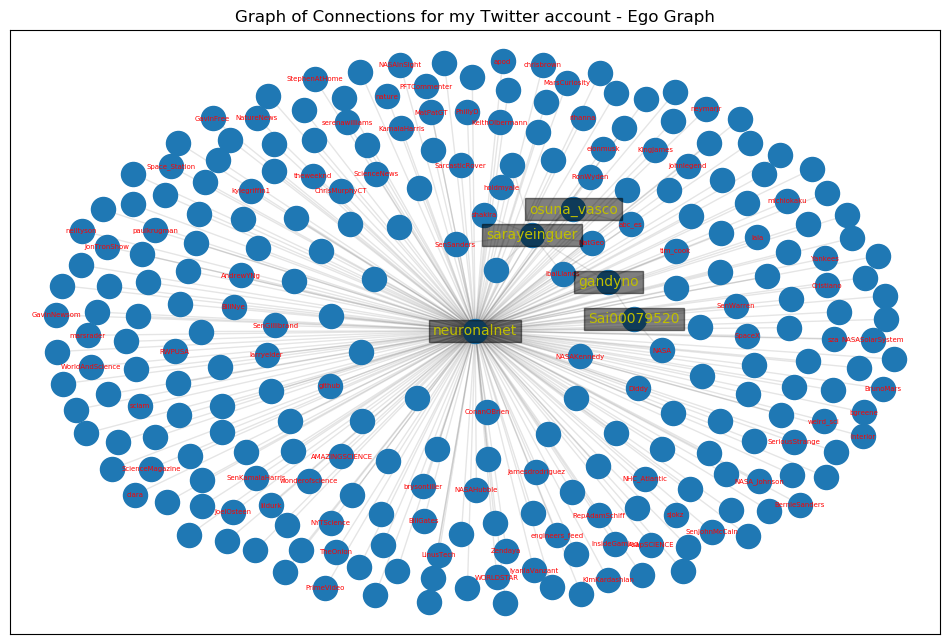

Density of 1.5-degree ego-net for neuronalnet  is: 0.008081170871868546  and number of edges 270
2.1819161354045074


In [457]:
# Create adjacency Ego table table from the table of connections and 
np.random.seed(53)
subg = nx.ego_graph(G,base,1)
bbox = dict(fc="black", ec="black",alpha = 0.5, boxstyle="square", lw=1)
#labels3 = color_labels(subg,node_in3)
#subg.remove_node(base)
influencers_me, weights_normalized_me = get_weights(combined_me,dfg = dfg_me ,filter_thres = 1)
node_in_me = np.concatenate([influencers_me.index.to_series().values])
labels_me = color_labels(subg,node_in_me)
pos_ego = nx.spring_layout(subg)

nx.draw_networkx_nodes(subg,pos = pos_ego)
nx.draw_networkx_edges(subg,pos = pos_ego, alpha = 0.1)
nx.draw_networkx_labels(subg,pos = pos_ego,labels = labels_me,font_size=5,font_color='r')
nx.draw_networkx_labels(subg,pos = pos_ego,labels = labels1,font_size=10,font_color='y', font_weight = 'normal',bbox = bbox)
plt.title('Graph of Connections for my Twitter account - Ego Graph')
plt.show()

#plt.title('Ego Graph of Connections for my Twitter account - Filtered')
#plt.show()
print("Density of 1.5-degree ego-net for",base,' is:', nx.density(subg), ' and number of edges',nx.number_of_edges(subg))
print(nx.density(subg)*nx.number_of_edges(subg))


We can see that the density for my individual graph is lower than the average for the total. So I have less number of conectedness than the average hub. We can check this value for all the other friends

In [459]:
for x in sample:
    subg = nx.ego_graph(G,x,1)
    print("Density of 1.5-degree ego-net for",x,' is:', nx.density(subg), ' and number of edges',nx.number_of_edges(subg))
    print("The normalized Density for ",x, "is:",nx.density(subg)*nx.number_of_edges(subg))


Density of 1.5-degree ego-net for osuna_vasco  is: 0.020146520146520148  and number of edges 110
The normalized Density for  osuna_vasco is: 2.2161172161172162
Density of 1.5-degree ego-net for gandyno  is: 0.009824957651044608  and number of edges 261
The normalized Density for  gandyno is: 2.5643139469226424
Density of 1.5-degree ego-net for Sai00079520  is: 0.17582417582417584  and number of edges 16
The normalized Density for  Sai00079520 is: 2.8131868131868134
Density of 1.5-degree ego-net for sarayeinguer  is: 0.007508305647840532  and number of edges 339
The normalized Density for  sarayeinguer is: 2.5453156146179405


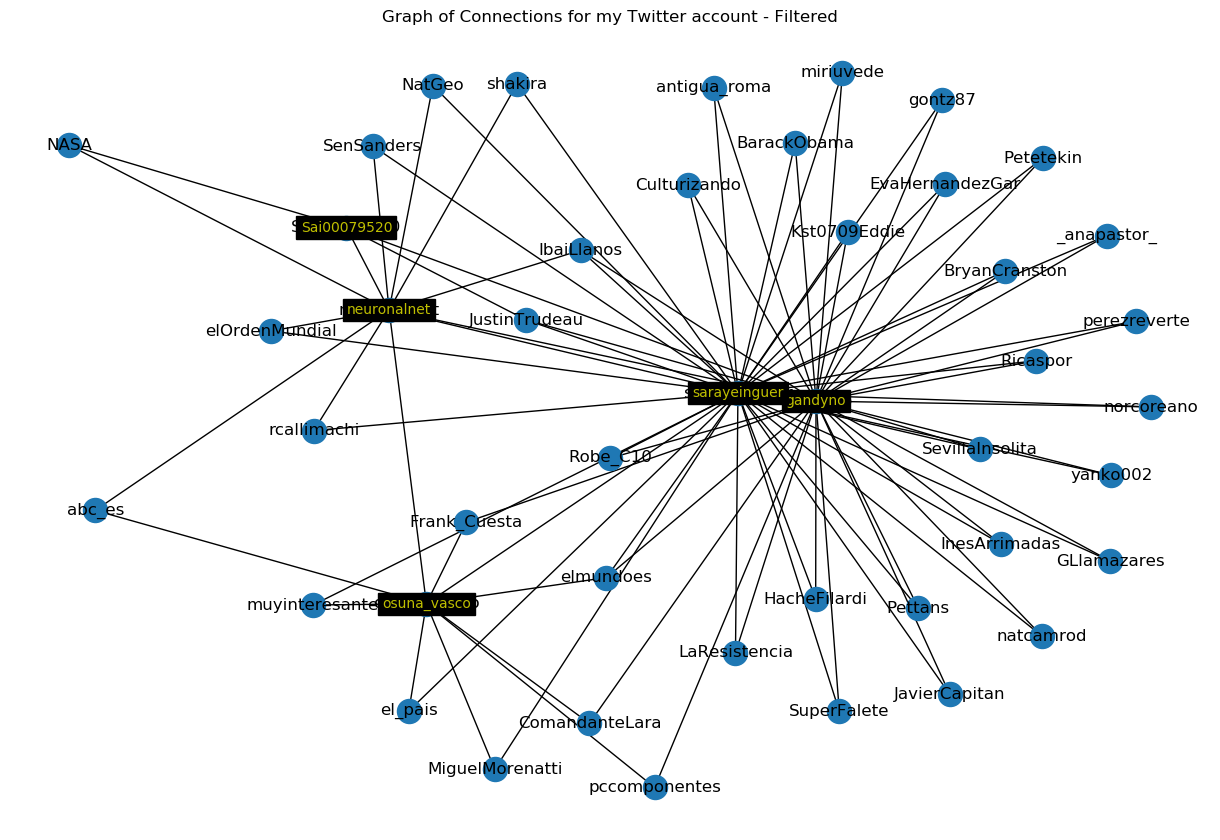

In [476]:
# Create adjacency table from the table of connections and 
np.random.seed(42)
bbox = dict(fc="black", ec="black", boxstyle="square", lw=1)
G = nx.from_pandas_adjacency(dfg2)
pos = nx.spring_layout(G)
nx.draw(G,pos = pos,with_labels=True)
plt.title('Graph of Connections for my Twitter account - Filtered')
nx.draw_networkx_labels(G,pos = pos,labels = labels1,font_size=10,font_color='y', font_weight = 'normal',bbox = bbox)
plt.show()

From this we see that my friends show larger density than I do. So as a result I could say that I'm less connected than my friends on average. This is not surprising given that my Twitter account is more focused on Data Science rather than mainstream news. As a result my connections are not part of the tribe.